# About trying with a pdf corpus

We first tried building a "corpus" based on: 

+ Deeptech documents: selected (in English and specifically about Deep Tech) pdf reports of Hello Tomorrow 
+ Non-deeptech documents: similar documents but not about Deep Tech

then using it to train a Word2Vec embedding and visualising the results, to see if clear clusters emerged.  

In [8]:
import pandas as pd

In [9]:
# Adding Hello_Tomorrow pdfs using pdfminer on command-line interface
# using them as 'deeptech' source

df = pd.DataFrame(columns=['text','is_deep_tech'])

l = !ls ../raw_data/Hello_tomorrow_files_EN

for i, file_name in enumerate(l):
    file_path = '../raw_data/Hello_tomorrow_files_EN/' + file_name
    file_text = !pdf2txt.py {file_path}
    df.loc[file_name,'text'] = ' '.join(file_text)
    df.loc[file_name,'is_deep_tech'] = 1

In [10]:
#Now doing the same for non-deeptech documents

l_2 = !ls ../raw_data/Non_deeptech_EN

for file_name in (l_2):
    file_path = '../raw_data/Non_deeptech_EN/' + file_name
    file_text = !pdf2txt.py {file_path}
    df.loc[file_name,'text'] = ' '.join(file_text)
    df.loc[file_name,'is_deep_tech'] = 0

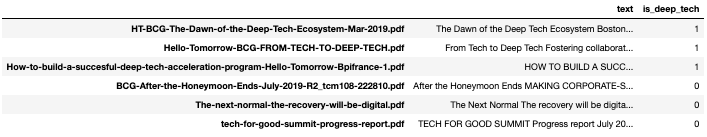

In [15]:
# The 'pdf corpus' dataframe
df

from IPython.display import Image
Image("pdf_corpus_df.png", width = 1000)

In [46]:
#for the time being, using those pdf files as X_train 
from gensim.models import Word2Vec
import csv

# preprocessing the text from the pdfs
df['processed_text'] = df['text'].map(text_preprocessing)

my_embedding = Word2Vec(sentences=df['processed_text'], min_count=7, window=5)

The visualization shows that no unsupervised clusters emerged. (Indeed two clusters emerged but when examining the words inside, there was no clear difference between them).
However, we graphed _words_ and not full sentences, therefore the visualization may not be representative of anything. 

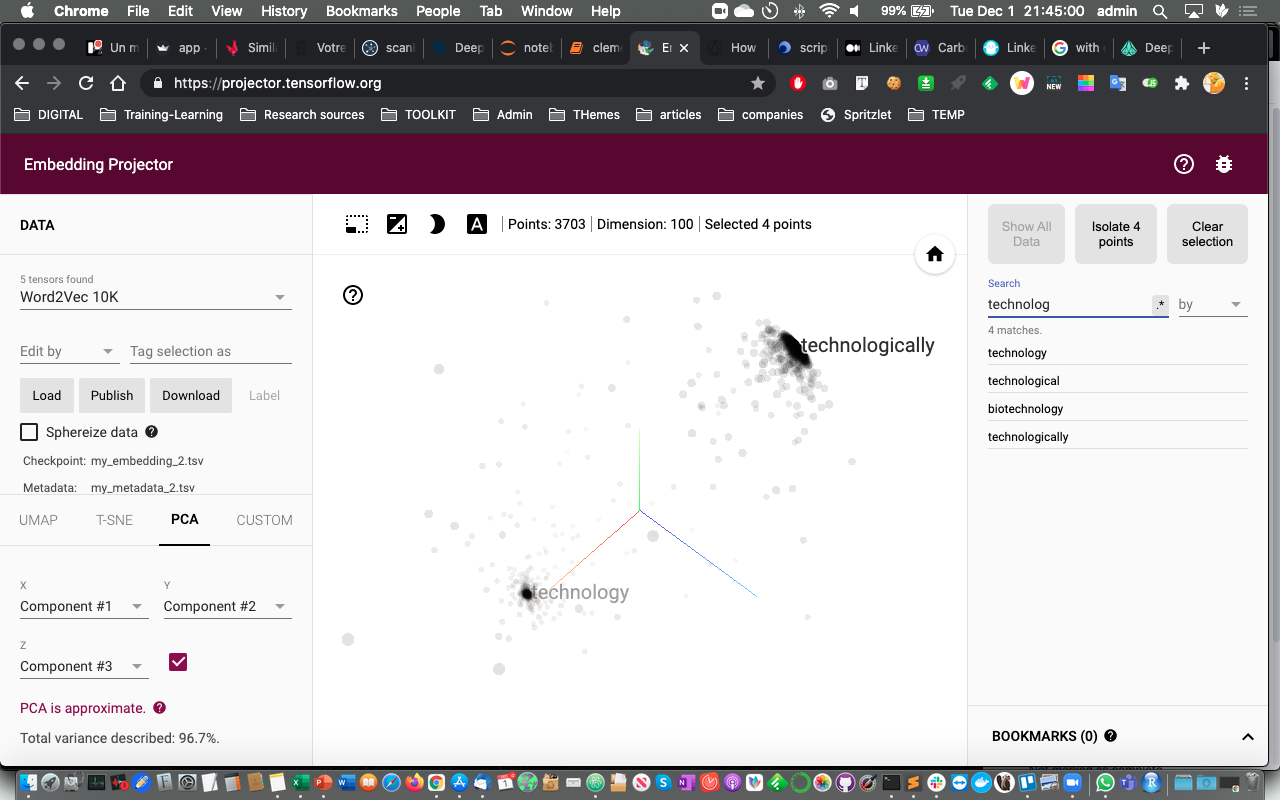

In [3]:
Image("not very conclusive t-SNE on corpuses.png")

---
# About observation of words in meta descriptions

Subsequently, we abandonned the lead of a corpus based on Hello Tomorrow pdfs. 
Instead, we fit a Word2Vec embedding on preprocessed meta_description, then used it to vectorize the list of words as an array of vectors.
Flattening the arrays in lists and cropping at the shortest list (≈200 coordinates).
Using Embedding Projector to reduce dimensionnality.

+ **Without supervision, no clusters** emerge
+ But **with supervision on target, clear clusters emerge** (but not fully separate)

The dimensionnality reduction may not be fully significant, as the sentences (arrays of vectors) were flattened to fit the 'TSV' (tab separated values) format required by the embedding projector, and cropped. 
However, 

+ we observed with hope that a supervised learning had chances to succeed (as cluster emerged when supervised)
+ more importantly, we observed that **companies labelled 'almost deeptech' were not forming a cluster of their own; but were floating in the middle between deep tech and non deep tech.** Meaning they were more a "grey zone" than a distinct category. 

For that second reason, **we decided to drop the 'almost deeptech' from the dataset, instead of attempting a three-layered classification.**

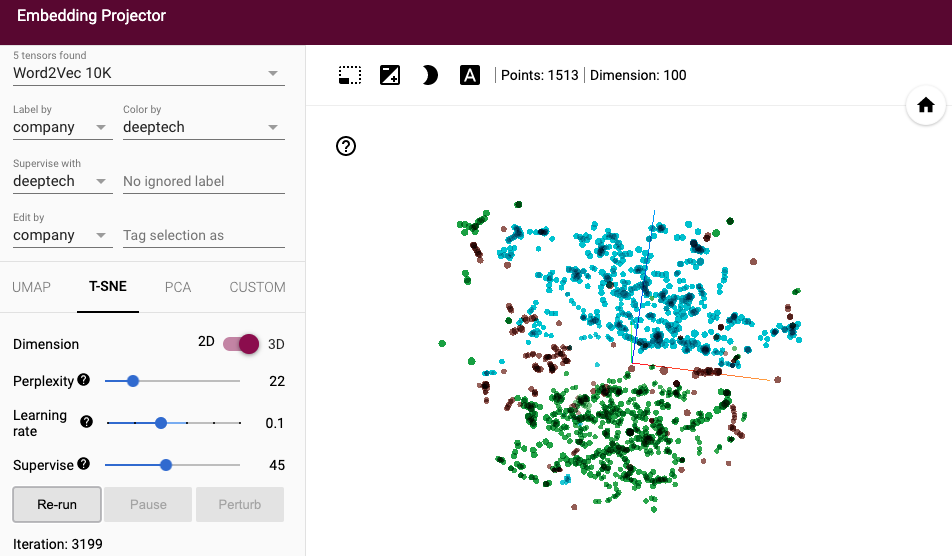

In [4]:
Image("apparent supervized clusters in projector.png")

---
# About Dealroom News


+ Importing **Dealroom news** from individual API queries (2' for 1513 companies) 


Only 45% of the companies in our dataset had any news in Dealroom. Dealroom confirmed that approximate proportion, as they only strive to retrieve funding news.  

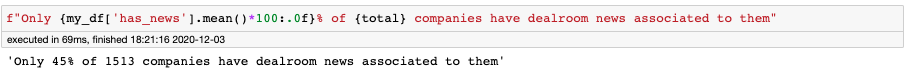

In [1]:
Image("45%Dealroom_news.png")

Descriptions are mostly in English, but also encompass other languages (French, German, Japanese…), with no language marker.

> => For both Google news and other sources (eg Meta descriptions), you might want to use a language detection and translation API (eg that of Google, free until 500k characters)

For these reasons, **we decided to NOT train a model on Dealroom news**.

---
# About scraping meta description from companies websites

We used the company websites addresses as given by the Dealroom API ('website_url" in raw data file).
652 companies out of the 1513 throw an exception or error, because:
    
+ the company does not have a meta-description tag, ex.: https://www.addidream.com/en/home/
+ the website url is incorrect (error 404), ex.: http://www.acubens-biotech.com/
+ the website url is nan
+ in one case, not only the website leads to a deadend, but also instead of returning an error code (400) it returns a succes code (200) with error 404 text as the response. This 'breaks' the result file so we remove this site in the scraping code

We remove also other sites that yield uninteresting data (empty except company name, or all in French) to get more useful data for training. 

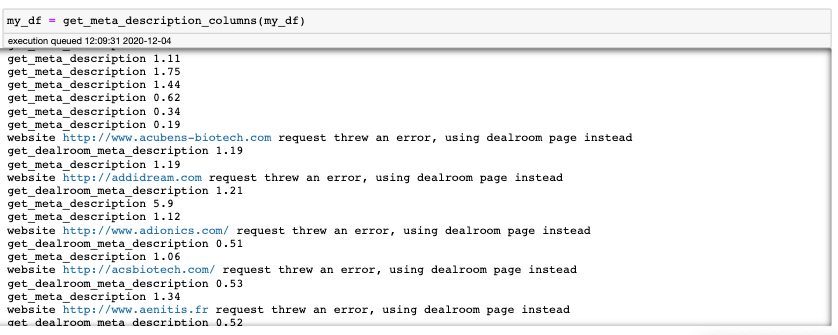

In [5]:
Image("meta_tags_errors.png")

Because of all the missing sites, **we concatenated the meta description + the Dealroom 'tagline' field in a 'full_text' field** on which the training was done.

---
# Transfer learning: embedding using an existing corpus

Because of the limited size of our own corpus (c. 1500 descriptions of a few tenths of words each), we decided to  embed the descriptions based on a pretrained model, trained on a large wikipedia + news corpus (400,000 words).

We explored different possible existing embeddings, to see if some were more suited to the 'tech' landscape. No clear winner emerged qualitatively, so **we took the largest vocabulary, glove-wiki-gigaword-300** (which explains the loading time when the API or the program starts)

+ "glove-wiki-gigaword-50" 

```
word2vec_wiki.wv.similar_by_vector(word2vec_wiki.wv["tech"])
[('tech', 1.0),
 ('technology', 0.7613498568534851),
 ('computer', 0.7384644150733948),
 ('electronics', 0.696427047252655),
 ('chip', 0.6770018339157104),
 ('advanced', 0.6500986814498901),
 ('helped', 0.6468499302864075),
 ('texas', 0.6434584856033325),
 ('giants', 0.6376305222511292),
 ('new', 0.6368595361709595)]
 
word2vec_wiki.wv.similar_by_vector(word2vec_wiki.wv["biotech"])
[('biotech', 0.9999998807907104),
 ('biotechnology', 0.8968190550804138),
 ('pharmaceutical', 0.7750740647315979),
 ('monsanto', 0.7580938935279846),
 ('pharmaceuticals', 0.7183324694633484),
 ('amgen', 0.7021055221557617),
 ('agribusiness', 0.6887552738189697),
 ('tobacco', 0.684147298336029),
 ('coca', 0.6837125420570374),
 ('growers', 0.6813806891441345)]
 
word2vec_wiki.wv.similar_by_vector(word2vec_wiki.wv["nanotech"])
[('nanotech', 1.0),
 ('neuromarketing', 0.6937649250030518),
 ('nanomaterials', 0.6913321614265442),
 ('tajura', 0.6881071329116821),
 ('biomaterials', 0.6880257725715637),
 ('nanotechnology', 0.667823076248169),
 ('opencourseware', 0.666871190071106),
 ('cryogenics', 0.6645549535751343),
 ('brooktrout', 0.6638575792312622),
 ('sematech', 0.6508078575134277)]
 
a healthtech mais voisins non pertinents
```

 
+ "glove-twitter-200" 

```
word2vec_wiki.wv.similar_by_vector(word2vec_wiki.wv["tech"])

[('tech', 1.0),
 ('technology', 0.7984446883201599),
 ('startup', 0.6608036160469055),
 ('innovation', 0.6581680774688721),
 ('mobile', 0.6376364231109619),
 ('business', 0.6348487138748169),
 ('startups', 0.6202924847602844),
 ('industry', 0.6104779839515686),
 ('software', 0.6068009734153748),
 ('hardware', 0.5987409949302673)]

word2vec_wiki.wv.similar_by_vector(word2vec_wiki.wv["biotech"])
[('biotech', 1.0),
 ('pharma', 0.7436743974685669),
 ('pharmaceutical', 0.6674783229827881),
 ('biotechnology', 0.6603209972381592),
 ('r&d', 0.5450037717819214),
 ('agribusiness', 0.5266454815864563),
 ('gmo', 0.5218278765678406),
 ('companies', 0.5205241441726685),
 ('mining', 0.5202422142028809),
 ('biomedical', 0.5143028497695923)]

word2vec_wiki.wv.similar_by_vector(word2vec_wiki.wv["nanotech"])
[('nanotech', 0.9999999403953552),
 ('nanotechnology', 0.5042550563812256),
 ('wral', 0.412231981754303),
 ('geospatial', 0.4091745913028717),
 ('v-log', 0.40346983075141907),
 ('stemcells', 0.39966756105422974),
 ('futurism', 0.3994828462600708),
 ('polymer', 0.39364707469940186),
 ('avionics', 0.38799867033958435),
 ('photonics', 0.38585394620895386)]

n'a pas healthtech

 ```
+ see also patent-2017 in https://github.com/RaRe-Technologies/gensim-data or here https://www.kite.com/python/docs/gensim.downloader


----
# About the "dummy" baseline and the RNN 

A calculation with a "dummy" model that just predicts always the same answer, the most frequent one, whatever the input, showed an accuracy and other metrics of about 50%. 
From the first run, our Recurrent Neural Network (RNN) of the Long Short-term memory kind (LSTM) had slightly better performances than the dummy baseline (60%+), but subsequent ameliorations (of the network parameters and of the cleanliness/significance of the data) lead to a precision, on a randomly set aside validation set, above 80%.

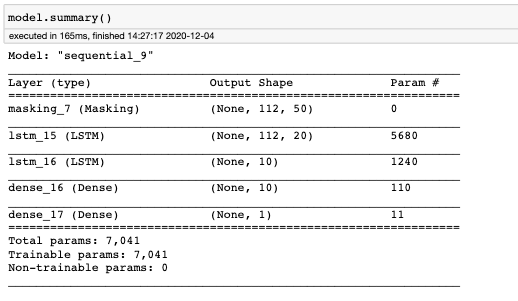

In [16]:
Image("initial_RNN.png")

See file **NLP_model_manual_grid_search.xlsx** in "documentation" folder for an overview of hyperparameters considered.